In [1]:
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, ZeroPadding2D, Conv2DTranspose
from keras.models import Model
from keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
import keras
import tensorflow as tf

2023-07-31 18:00:25.471548: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 18:00:29.509759: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/aaslan/venv-jupyter-310/lib/python3.8/site-packages/cv2/../../lib64:
2023-07-31 18:00:29.510029: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/aaslan/venv-jupyter-310/lib/python3.8/site-packag

In [2]:
SIZE = 256
image_s =[]
dataset_s=[]
image_labels = []
image_directory_2  = 'good/'
good_images_2 = os.listdir(image_directory_2)
for i, image_name in enumerate(good_images_2):
    if (image_name.endswith('png')):
        image_s = cv2.imread(image_directory_2 + image_name)
        image_s = Image.fromarray(image_s,'RGB')
        image_s = image_s.resize((SIZE, SIZE)) 
        dataset_s.append(np.array(image_s))
dataset_s = np.array(dataset_s)
train_x = dataset_s[0:450]
train_x = train_x.astype('float32') / 255.
val_x = dataset_s[450:500]
val_x = val_x.astype('float32') / 255.
test_good_x = dataset_s[450:500]
test_good_x = test_good_x.astype('float32') / 255.

In [3]:
img_rows, img_cols, channels = 256, 256, 3
input_shape = (img_rows, img_cols, channels)
latent_dim = 128

In [4]:
latent = 128
def build_encoder():
    model = keras.Sequential()
    model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=input_shape, padding="same", activation='relu'))
    model.add(Conv2D(32, kernel_size=3, strides=2, padding="same", activation='relu'))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same", activation='relu'))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same", activation='relu'))
    model.add(Flatten())
    model.add(Dense(latent, activation='relu'))
    model.summary()
    img = Input(shape=(256,256,3))
    validity = model(img)
    return Model(img, validity)

def build_decoder():
    model = keras.Sequential()
    model.add(Dense(16 * 16 * 128, activation='relu', input_shape=(latent,)))
    model.add(Reshape((16, 16, 128)))
    model.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation='relu'))
    model.add(Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", activation='relu'))
    model.add(Conv2DTranspose(16, kernel_size=3, strides=2, padding="same", activation='relu'))
    model.add(Conv2DTranspose(3, kernel_size=3, strides=2, padding="same", activation='tanh'))
    model.summary()
    encoded_repr = Input(shape=(latent,))
    img = model(encoded_repr)
    return keras.Model(encoded_repr, img)

In [5]:
def build_discriminator():


    model = keras.Sequential()
    model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=input_shape, padding="same", activation='relu'))
    model.add(Conv2D(32, kernel_size=3, strides=2, padding="same", activation='relu'))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same", activation='relu'))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same", activation='relu'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    img = Input(shape=input_shape)
    validity = model(img)
    return Model(img, validity)

In [9]:
print(finish)

16.043238401412964


In [6]:
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Build the generator
generator = build_decoder()

# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)


# The discriminator takes generated images as input and determines validity
valid = discriminator(img)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1)                 32769     
                                                                 
Total params: 130,209
Trainable params: 130,209
Non-trai

In [ ]:
from keras.optimizers import Adam
import matplotlib.pyplot as plt

# Define the Optimizer
optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=optimizer,
                      metrics=['accuracy'])

# Build the generator
generator = build_decoder() # We're still using decoder as generator

# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

def train(epochs, batch_size=32):
    X_train = train_x

    # Labels for real and fake examples
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        discriminator.trainable = True
        # Select a random half batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Sample noise and generate a half batch of new images
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(noise)

        # Train the discriminator (real classified as ones and generated as zeros)
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        discriminator.trainable = False
        # Train the generator (wants discriminator to mistake images as real)
        g_loss = combined.train_on_batch(noise, valid)

        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
        if epoch % 30 == 0:
            noise = np.random.normal(0, 1, (2, latent_dim))  # we want 5 images
            gen_imgs = generator.predict(noise)
            fig, axs = plt.subplots(1, 2)
            for i in range(2):
                axs[i].imshow(gen_imgs[i])
                axs[i].axis('off')
            plt.show()
start = time.time()
train(20000,32)
end = time.time()
finish = end-start

In [48]:
generator = keras.models.load_model('gen.h5')
encoder = build_encoder()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 conv2d_17 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 flatten_4 (Flatten)         (None, 32768)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               4194432   
                                                                 
Total params: 4,291,872
Trainable params: 4,291,872
No

In [301]:

encoder = build_encoder()

# # Freeze weights of the generator
generator.trainable = False

# The encoder will try to convert real images into latent vectors
real_imgs = Input(shape=(img_rows, img_cols, channels))
encoded_imgs = encoder(real_imgs)

# Then the generator will try to convert these vectors back to images
decoded_imgs = generator(encoded_imgs)

# This model maps an input to its reconstruction'
izi = Model(real_imgs, decoded_imgs)

# We'll use MSE (Mean Squared Error) as the loss function
izi.compile(optimizer='adam', loss='mse')

# Train the model
izi.fit(train_x, train_x, epochs=200, batch_size=32)


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
flatten_6 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               4194432   
Total params: 4,291,872
Trainable params: 4,291,872
Non-trainable params: 0
____________________________________________

Epoch 83/200
15/15 [==============================] - 1s 93ms/step - loss: 1.3826e-04
Epoch 84/200
15/15 [==============================] - 1s 95ms/step - loss: 1.3770e-04
Epoch 85/200
15/15 [==============================] - 1s 94ms/step - loss: 1.3750e-04
Epoch 86/200
15/15 [==============================] - 1s 95ms/step - loss: 1.3762e-04
Epoch 87/200
15/15 [==============================] - 1s 94ms/step - loss: 1.3798e-04
Epoch 88/200
15/15 [==============================] - 1s 94ms/step - loss: 1.3765e-04
Epoch 89/200
15/15 [==============================] - 1s 95ms/step - loss: 1.3767e-04
Epoch 90/200
15/15 [==============================] - 1s 93ms/step - loss: 1.3767e-04
Epoch 91/200
15/15 [==============================] - 1s 95ms/step - loss: 1.3792e-04
Epoch 92/200
15/15 [==============================] - 1s 93ms/step - loss: 1.3742e-04
Epoch 93/200
15/15 [==============================] - 1s 91ms/step - loss: 1.3738e-04
Epoch 94/200
15/15 [==============================] - 

KeyboardInterrupt: 

In [20]:
generator.trainable = False

z = Input(shape=(latent_dim,))
img = generator(z)
z_1 = encoder(img)

# This model maps an input to its reconstruction
ziz = Model(z, z_1)
opt = Adam(learning_rate=0.0001)
ziz.compile(optimizer=opt, loss='mse')

for epoch in range(200):
    noise = np.random.normal(0, 1, (32, latent_dim))
    # Here, we're using the original noise as the target
    loss = ziz.train_on_batch(noise, noise)
    print(loss)


0.9833387136459351
0.9855809211730957
0.9579366445541382
1.0007209777832031
1.0289266109466553
1.0020167827606201
0.995296835899353
1.0646581649780273
1.031540870666504
1.020200490951538
1.0092198848724365
0.9873488545417786
1.0219480991363525
0.9899705648422241
1.0322039127349854
1.0109432935714722
1.0036996603012085
1.0143914222717285
0.9619404077529907
0.9733428955078125
1.0001697540283203
1.016077995300293
1.0104846954345703
0.9887536764144897
0.9345064163208008
1.0045897960662842
0.9590834379196167
0.9651523232460022
1.0061203241348267
1.0339155197143555
0.9861606359481812
0.9977825880050659
1.0337345600128174
0.9899400472640991
0.9893127679824829
0.9983495473861694
0.9780346155166626
0.9866478443145752
1.0020432472229004
1.0340461730957031
0.9652544260025024
1.0033211708068848
1.0032944679260254
0.9686368703842163
0.9989767074584961
0.9686527252197266
0.9503610134124756
0.9897738695144653
0.9736346006393433
1.0082954168319702
0.9972095489501953
1.0542826652526855
0.99989473819732

In [51]:
from keras.models import Model
from keras.losses import mean_squared_error
import time
start_time = time.time()
# Extract features from discriminator
discriminator_intermediate = Model(discriminator.input, 
                                   outputs=[discriminator.layers[-2].output])
# generator.trainable = False 
# Freeze its layers
for layer in discriminator_intermediate.layers:
    layer.trainable = False
generator.trainable = False
# Construct the feature matching loss function
def feature_matching_loss(y_true, y_pred):
    return mean_squared_error(discriminator_intermediate(y_true),
                              discriminator_intermediate(y_pred))
# The encoder will try to convert real images into latent vectors
real_imgs = Input(shape=(img_rows, img_cols, channels))
encoded_imgs = encoder(real_imgs)

# Then the generator will try to convert these vectors back to images
decoded_imgs = generator(encoded_imgs)

# The izif model
izif = Model(real_imgs, decoded_imgs)

# Compile model with combined loss
izif.compile(optimizer='adam', loss=[feature_matching_loss, 'mse'], 
             loss_weights=[1., 1.])  # adjust weights if necessary

# Train the model
izif.fit(train_x, [train_x, train_x], epochs=200, batch_size=32)
finish = time.time()
print('total', start_time-finish)


Epoch 1/200
15/15 [==============================] - 2s 18ms/step - loss: 4.5523e-05
Epoch 2/200
15/15 [==============================] - 0s 16ms/step - loss: 4.3849e-05
Epoch 3/200
15/15 [==============================] - 0s 17ms/step - loss: 4.0050e-05
Epoch 4/200
15/15 [==============================] - 0s 16ms/step - loss: 3.8573e-05
Epoch 5/200
15/15 [==============================] - 0s 16ms/step - loss: 3.7783e-05
Epoch 6/200
15/15 [==============================] - 0s 15ms/step - loss: 3.7503e-05
Epoch 7/200
15/15 [==============================] - 0s 14ms/step - loss: 3.7368e-05
Epoch 8/200
15/15 [==============================] - 0s 14ms/step - loss: 3.6765e-05
Epoch 9/200
15/15 [==============================] - 0s 14ms/step - loss: 3.7102e-05
Epoch 10/200
15/15 [==============================] - 0s 15ms/step - loss: 3.6712e-05
Epoch 11/200
15/15 [==============================] - 0s 16ms/step - loss: 3.7069e-05
Epoch 12/200
15/15 [==============================] - 0s 16ms/s

15/15 [==============================] - 0s 14ms/step - loss: 2.6382e-05
Epoch 191/200
15/15 [==============================] - 0s 13ms/step - loss: 2.6403e-05
Epoch 192/200
15/15 [==============================] - 0s 13ms/step - loss: 2.6425e-05
Epoch 193/200
15/15 [==============================] - 0s 13ms/step - loss: 2.6347e-05
Epoch 194/200
15/15 [==============================] - 0s 13ms/step - loss: 2.6394e-05
Epoch 195/200
15/15 [==============================] - 0s 13ms/step - loss: 2.6368e-05
Epoch 196/200
15/15 [==============================] - 0s 13ms/step - loss: 2.6488e-05
Epoch 197/200
15/15 [==============================] - 0s 13ms/step - loss: 2.6376e-05
Epoch 198/200
15/15 [==============================] - 0s 13ms/step - loss: 2.6383e-05
Epoch 199/200
15/15 [==============================] - 0s 13ms/step - loss: 2.6338e-05
Epoch 200/200
15/15 [==============================] - 0s 13ms/step - loss: 2.6395e-05
total -44.495819091796875


In [49]:
discriminator = keras.models.load_model('gan.h5')

In [50]:
discriminator = discriminator.get_layer(name="sequential")

In [25]:
encoder_input = Input(shape=(256,256,3))

encoded_repr = encoder(encoder_input)

# Decode the representation
reconstructed_img = generator(encoded_repr)

# Define the autoencoder model
autoencoder = Model(encoder_input, reconstructed_img)

In [21]:
SIZE = 256
image_s2 =[]
dataset_s2=[]
image_labels2 = []

image_directory_22  = 'bad/'
bad_images = os.listdir(image_directory_22)
for i, image_name in enumerate(bad_images):
    if (image_name.endswith('png')):
        image_s2 = cv2.imread(image_directory_22 + image_name)
        image_s2 = Image.fromarray(image_s2,'RGB')
        image_s2 = image_s2.resize((SIZE, SIZE))
        dataset_s2.append(np.array(image_s2))
        
bad_dataset = np.array(dataset_s2)
bad_dataset = bad_dataset.astype('float32') / 255.

In [52]:
autoencoder = izif

In [53]:
X_good_recon = autoencoder.predict(test_good_x)
X_test_recon = autoencoder.predict(bad_dataset)
val_recon =  autoencoder.predict(val_x)

2/2 [==============================] - 0s 5ms/step


In [54]:
from skimage import measure, filters
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import gaussian
def anomaly_map_val(inp, outp):
    inp_gray = np.mean(inp, axis=2)
    outp_gray = np.mean(outp, axis=2)
    re = np.abs(inp - outp)
#     re = np.mean(re, axis=-1, keepdims=True)
    re.shape
    inp_blurred = cv2.GaussianBlur(inp_gray, (3, 3), 0)
    thresh = filters.threshold_otsu(inp_blurred - 0.035)
    binary_image = (inp_blurred > thresh).astype(np.uint8) * 255
    contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    black = np.zeros_like(inp_gray)
    contour = cv2.drawContours(binary_image, contours, -1, (0, 0, 0), 2)
    contour_array = np.asarray(contour)
    plt.imshow(contour_array)
    for i in range (re.shape[0]):
        for j in range (re.shape[0]):
            if contour_array[i,j] == 0:
                re[i,j] = 0

    return re

3/3 [==============================] - 0s 6ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


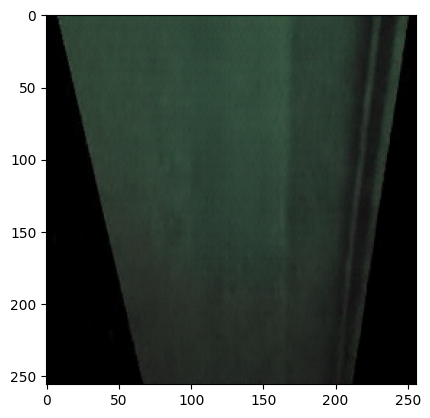

In [ ]:
x = autoencoder.predict(bad_dataset)
plt.imshow(x[0])

In [56]:
from skimage import filters
def anomaly_map_roc(inp, outp):
    inp_gray = np.mean(inp, axis=2)
    outp_gray = np.mean(outp, axis=2)
    re = (inp - outp)**2
    re = np.mean(re, axis=-1, keepdims=True)
    re.shape
    inp_blurred = cv2.GaussianBlur(inp_gray, (3, 3), 0)
    thresh = filters.threshold_otsu(inp_blurred - 0.035)
    binary_image = (inp_blurred > thresh).astype(np.uint8) * 255
    contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    black = np.zeros_like(inp_gray)
    contour = cv2.drawContours(binary_image, contours, -1, (0, 0, 0), 2)
    contour_array = np.asarray(contour)
    for i in range (re.shape[0]):
        for j in range (re.shape[0]):
            if contour_array[i,j] == 0:
                re[i,j] = 0
    min_value = np.min(re)  # Find the minimum value greater than 0
    max_value = np.max(re)  # Find the maximum value
    recon_error = re 
    normalized_x = (recon_error - min_value) / (max_value - min_value)
    anomaly_map = (recon_error - np.min(recon_error)) / (np.max(recon_error) - np.min(recon_error))
    return anomaly_map

In [57]:
result = []
for i in range(bad_dataset.shape[0]):
    result.append(anomaly_map_roc(bad_dataset[i], X_test_recon[i]))
result = np.array(result)

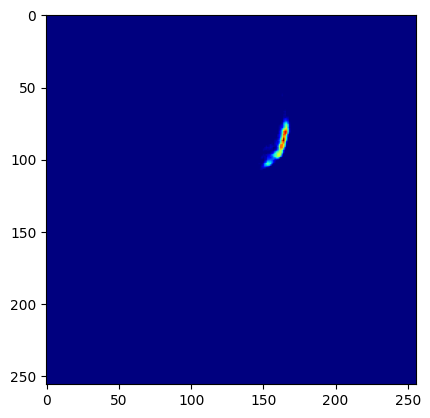

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm  # Import the cm module for colormaps

heatmaps_array = np.zeros((result.shape[0], result.shape[1], result.shape[2], 3), dtype=np.uint8)

# Define your color thresholds
lower_threshold = 0.  
upper_threshold = 1  

for i in range(result.shape[0]):
    anomaly_map = result[i, :, :, 0] 

    norm = colors.Normalize(vmin=lower_threshold, vmax=upper_threshold, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap='jet')  # Replace 'jet' with any other colormap if you wish


    colored_map = mapper.to_rgba(anomaly_map)

    colored_map = (colored_map[:, :, :3] * 255).astype(np.uint8)

    # Store the heatmap in the array
    heatmaps_array[i] = colored_map

plt.imshow(heatmaps_array[11])


In [78]:
import os
import cv2

output_dir = 'outauto'
o_2 = 'org'

for i in range (result.shape[0]):
    file_name = f"{i}.png"
    n_2 = f"{i}.png"

    file_path = os.path.join(output_dir, file_name)  # Combine directory path and file name
    file_path_2 = os.path.join(o_2, n_2)
    rgb_map = cv2.cvtColor(heatmaps_array[i], cv2.COLOR_BGR2RGB)

    cv2.imwrite(file_path, rgb_map)

In [63]:
import os
import cv2

output_dir = 'outauto'
o_2 = 'org'

for i in range (result.shape[0]):
    file_name = f"{i}.png"
    n_2 = f"{i}.png"

    file_path = os.path.join(output_dir, file_name)  # Combine directory path and file name
    file_path_2 = os.path.join(o_2, n_2)
    
    cv2.imwrite(file_path, result[i]*255)

In [79]:
import shutil

def zip_file(file_path, zip_path):
    shutil.make_archive(zip_path, 'zip', file_path)

# Specify the file path and the desired zip file path
file_path = 'outauto'
zip_path = 'auto'

# Call the function to create the zip file
zip_file(file_path, zip_path)


# Thresholding 

In [ ]:
val_recon_error = []
for i in range (val_x.shape[0]):
    val_recon_error.append(anomaly_map_val(val_x[i], val_recon[i]))
val_recon_error = np.array(val_recon_error)

In [79]:
maxvalues = [np.max(val_recon_error[i].flatten()) for i in range(val_recon_error.shape[0])]
maxvalues = np.array(maxvalues)

In [60]:
izif.save('izif.h5')

In [80]:
import numpy as np
from scipy import stats

# Calculate the mean and standard deviation of the dataset
mean = np.mean(maxvalues)
std = np.std(maxvalues)

# Define the threshold for anomalies
threshold = mean + 3 * std  # Adjust the multiplier as needed

# Perform Z-test for each value in the dataset
z_scores = (maxvalues - mean) / std

# Identify anomalies based on the threshold
anomalies = maxvalues[z_scores > threshold]

# Print the anomalies
print("Anomalies:", anomalies)
maxvalues = maxvalues[z_scores <= threshold]

# Print the non-anomalous values
print("Non-anomalous values:", maxvalues)

Anomalies: [0.09456794 0.19007355 0.12875423 0.10296394 0.09124072 0.32717258
 0.09799936 0.09830786]
Non-anomalous values: [0.07157451 0.06235282 0.06165832 0.06443377 0.07062821 0.06478862
 0.06759995 0.07619935 0.07692389 0.06201714 0.06974594 0.06280676
 0.06920259 0.08845347 0.06884827 0.07245089 0.06744215 0.06496628
 0.07650314 0.07155946 0.07659929 0.07712154 0.07695003 0.07270758
 0.0645379  0.06579818 0.06633098 0.06344093 0.07878111 0.07633114
 0.06287573 0.07342079 0.06497177 0.05845208 0.07246888 0.06491883
 0.06283167 0.0784077  0.08260986 0.06497949 0.06859858 0.07101747]


In [81]:
from scipy import stats
maxvalues = np.array(maxvalues)
def get_best_distribution(data):
    dist_names = ['gamma', 'expon', 'lognorm', 'weibull_max', 'weibull_min', 'pareto', 'norm']
    dist_results = []
    params = {}

    for dist_name in dist_names:
        dist = getattr(stats, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = stats.kstest(data, dist_name, args=param)
        dist_results.append((dist_name, p))

    best_dist, best_p = max(dist_results, key=lambda x: x[1])

    return best_dist, params[best_dist]

best_dist, best_params = get_best_distribution(maxvalues)
print("Best distribution:", best_dist)
print("Best distribution parameters:", best_params)




Best distribution: gamma
Best distribution parameters: (4.868115596749209, 0.055329662475989, 0.002985594422600665)


In [82]:
def get_threshold_from_distribution(distribution, percentile):
    dist = getattr(stats, distribution)
    threshold = dist.ppf(percentile/100, *best_params)
    return threshold


best_dist = best_dist # Replace with the best-fitting distribution
best_params = (best_params[0], best_params[1], best_params[2])  # Replace with the best-fitting distribution parameters
percentile = 90  # Specify the desired percentile

threshold = get_threshold_from_distribution(best_dist, percentile) 
print("Threshold at {}th percentile: {}".format(percentile, threshold))

Threshold at 90th percentile: 0.07868444196524685


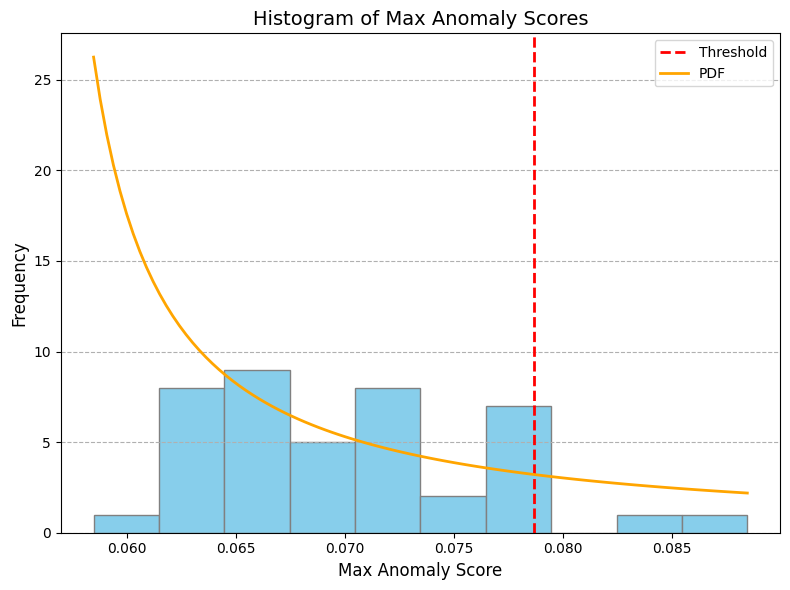

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


# Calculate the lognormal distribution parameters (replace with your values)
shape_param = best_params[0]
loc_param = best_params[1]
scale_param = best_params[2]

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(maxvalues, bins=10, color='skyblue', edgecolor='gray')
plt.axvline(x=threshold, color='r', linestyle='--', linewidth=2)
plt.xlabel('Max Anomaly Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Histogram of Max Anomaly Scores', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--')
plt.legend(['Threshold'], fontsize=10)

# Plot the lognormal distribution PDF
x = np.linspace(min(maxvalues), max(maxvalues), 100)
pdf = stats.lognorm.pdf(x, shape_param, loc=loc_param, scale=scale_param)
plt.plot(x, pdf, color='orange', linewidth=2)
plt.legend(['Threshold', 'PDF'], fontsize=10)
plt.tight_layout()
plt.show()


In [84]:
from skimage import filters
def anomaly_map_with_contours(inp, outp):
    inp_gray = np.mean(inp, axis=2)
    outp_gray = np.mean(outp, axis=2)
    re = np.abs(inp - outp)
    re = np.mean(re, axis=-1, keepdims=True)
    inp_blurred = cv2.GaussianBlur(inp_gray, (3, 3), 0)
    thresh = filters.threshold_otsu(inp_blurred - 0.03)
    binary_image = (inp_blurred > thresh).astype(np.uint8) * 255
    contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    black = np.zeros_like(inp_gray)
    contour = cv2.drawContours(binary_image, contours, -1, (0, 0, 0), 2)
    contour_array = np.asarray(contour)
    
    # Calculate the anomaly map excluding the contours
    anomaly_map = np.zeros_like(inp_gray)
    contour = contour.astype(np.int8)
    for i in range(anomaly_map.shape[0]):
        for j in range(anomaly_map.shape[1]):
            if contour_array[i,j] == 0:
                anomaly_map[i, j] = 0

            else:
                if re[i, j] >= threshold:
                    anomaly_map[i, j] = 1

    return anomaly_map


In [85]:
result = []
for i in range(bad_dataset.shape[0]):
    result.append(anomaly_map_with_contours(bad_dataset[i], X_test_recon[i]))
result = np.array(result)


In [86]:
import os
import cv2

output_dir = 'outauto'
o_2 = 'org'

for i in range (result.shape[0]):
    file_name = f"{i}.png"
    n_2 = f"{i}.png"

    file_path = os.path.join(output_dir, file_name)  # Combine directory path and file name
    file_path_2 = os.path.join(o_2, n_2)

    cv2.imwrite(file_path, result[i]*255)

In [87]:
import shutil

def zip_file(file_path, zip_path):
    shutil.make_archive(zip_path, 'zip', file_path)

# Specify the file path and the desired zip file path
file_path = 'outauto'
zip_path = 'auto'

# Call the function to create the zip file
zip_file(file_path, zip_path)


In [182]:
def tr(inp, out):
    res = inp-out
    re = np.mean(res, axis=-1)
    for i in range (inp.shape[0]):
        for j in range (inp.shape[0]):
            if re[i,j] >=0.07:
                re[i,j] = 1
            else: 
                re[i,j] = 0
    return re 

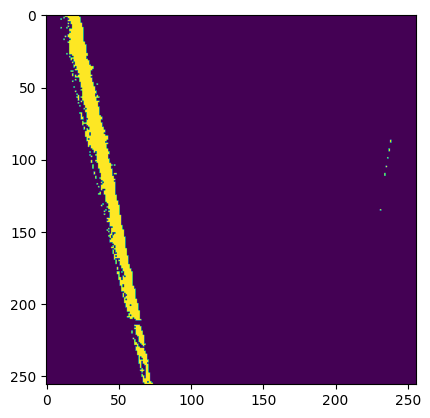

In [187]:
x = tr(bad_dataset[1], X_test_recon[1])
plt.imshow(x)